In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [54]:
import pandas as pd
import numpy as np
import re

from keras.preprocessing.text import Tokenizer
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import seaborn as sn
import time
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/content/linkedin.csv")

In [5]:
df.head()

,index,category,linkedin,profile_picture,description,Experience,Name,position,location,skills,clean_skills
0,1,HR,https://in.linkedin.com/in/sameer-wadhawan-b55...,https://media-exp1.licdn.com/dms/image/C5603AQ...,"An experienced HR professional, HR mentor and...",Senior Vice President & Head of HRCompany Name...,Sameer Wadhawan,Senior Vice President and Head of HR- Samsung ...,"Gurgaon, Haryana, India","['\nPerformance Management\n', '\nHuman Resour...","['Performance Management', 'Human Resources', ..."
1,2,HR,https://in.linkedin.com/in/adarsh-krishna-a4ab0a5,https://media-exp1.licdn.com/dms/image/C5103AQ...,"Head Talent Acquisition, HR Leader and Strateg...",Head of Talent Acquisition - India & APAC and ...,Adarsh Krishna,Head Talent Acquisition and HR Leader for Heal...,"Pune, Maharashtra, India","['\nTalent Acquisition\n', '\nEmployee Engagem...","['Talent Acquisition', 'Employee Engagement', ..."
2,3,HR,https://in.linkedin.com/in/shrivas-mohit,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP//...",A Talent Acquisition and HR professional with ...,Company NameIBM INDIA Pvt LtdTotal Duration8 y...,Shrivas Mohit,HR@IBM,"Bengaluru, Karnataka, India","['\nHuman Resources\n', '\nRecruiting\n', '\nT...","['Human Resources', 'Recruiting', 'Team Manage..."
3,4,HR,https://in.linkedin.com/in/hr-hopes-086734b8,"data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP//...",NaN,HR/Admin/Personnel/LegalCompany NameHR and HR ...,HR Hopes,HR,"Pune Area, India",[],['']
4,5,HR,https://in.linkedin.com/in/rakeshkumar01,https://media-exp1.licdn.com/dms/image/C5103AQ...,Over 18 Years of experience in IT /ITES / BPO...,Company NameEXLTotal Duration6 yrs 4 mosTitleV...,Rakesh Kumar,Vice President - Digital HR Transformation Lea...,"Central Delhi, Delhi, India","['\nTeam Management\n', '\nHuman Resources\n',...","['Team Management', 'Human Resources', 'Employ..."


In [6]:
df = df[['description', 'category']]
df.head()

,description,category
0,"An experienced HR professional, HR mentor and...",HR
1,"Head Talent Acquisition, HR Leader and Strateg...",HR
2,A Talent Acquisition and HR professional with ...,HR
3,NaN,HR
4,Over 18 Years of experience in IT /ITES / BPO...,HR


In [7]:
data = df.dropna() #Drop null rows

In [8]:
len(data) #Total rows

670

In [9]:
def preprocess_text(text): #Remove any special chars, numbers and convert to lowercase
  text = text.lower()

  pattern = r'[^a-zA-z\s]'
  text = re.sub(pattern, '', text)

  return text

In [10]:
data['description_preprocessed'] = data['description'].apply(preprocess_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
data.head()

,description,category,description_preprocessed
0,"An experienced HR professional, HR mentor and...",HR,an experienced hr professional hr mentor and ...
1,"Head Talent Acquisition, HR Leader and Strateg...",HR,head talent acquisition hr leader and strategi...
2,A Talent Acquisition and HR professional with ...,HR,a talent acquisition and hr professional with ...
4,Over 18 Years of experience in IT /ITES / BPO...,HR,over years of experience in it ites bpo wit...
5,Human Resources Business Partner with a demons...,HR,human resources business partner with a demons...


In [12]:
data['category'] = data['category'].apply(preprocess_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
data

,description,category,description_preprocessed
0,"An experienced HR professional, HR mentor and...",hr,an experienced hr professional hr mentor and ...
1,"Head Talent Acquisition, HR Leader and Strateg...",hr,head talent acquisition hr leader and strategi...
2,A Talent Acquisition and HR professional with ...,hr,a talent acquisition and hr professional with ...
4,Over 18 Years of experience in IT /ITES / BPO...,hr,over years of experience in it ites bpo wit...
5,Human Resources Business Partner with a demons...,hr,human resources business partner with a demons...
...,...,...,...
1241,Experienced Aircraft Maintenance Engineer with...,aviation,experienced aircraft maintenance engineer with...
1242,Aero-Business Professional |Independent Consul...,aviation,aerobusiness professional independent consulta...
1244,"I am Ritu Roy,born in India. i am an energetic...",aviation,i am ritu royborn in india i am an energeticam...
1248,An MBA Graduate specialized in Aviation Manage...,aviation,an mba graduate specialized in aviation manage...


In [36]:
embed_size = 300 # how big is each word vector
max_features = 10000 # how many unique words to use (i.e num rows in embedding vector). 1000
maxlen = 400 # max number of words in a description to use
batch_size = 425

In [37]:
X = list(data['description_preprocessed'].values)
y = list(data['category'].values)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [39]:
# Getting training and test data as tokenizer sequence 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train)+list(X_test))
train_X = tokenizer.texts_to_sequences(X_train)
test_X = tokenizer.texts_to_sequences(X_test)

In [40]:
train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=maxlen)

In [41]:
le = LabelEncoder()
train_y = le.fit_transform(y_train)
test_y = le.transform(y_test)

In [42]:
# Creating embedding matrix from pretrained glove vectors, matrix will be size (10000, 100)
def load_glove(word_index):
  EMBEDDING_FILE = '/content/drive/My Drive/AITS/glove.840B.300d.txt'
  def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = -0.005838499,0.48782197
  embed_size = all_embs.shape[1]

  nb_words = min(max_features, len(word_index)+1)
  embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
  for word, i in word_index.items():
      if i >= max_features: continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
      else:
          embedding_vector = embeddings_index.get(word.capitalize())
          if embedding_vector is not None:
              embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [43]:
embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [44]:
class CNN_Text(nn.Module):
  def __init__(self):
    super(CNN_Text, self).__init__()
    filter_sizes = [1,2,3,5]
    num_filters = 36
    n_classes = len(le.classes_)
    self.embedding = nn.Embedding(max_features, embed_size)
    self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
    self.embedding.weight.requires_grad = False
    self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
    self.dropout = nn.Dropout(0.1)
    self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)
  def forward(self, x):
    x = self.embedding(x)
    x = x.unsqueeze(1)
    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
    x = torch.cat(x, 1)
    x = self.dropout(x)
    logit = self.fc1(x)
    return logit

In [45]:
n_epochs = 70
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long)
y_train = torch.tensor(train_y, dtype=torch.long)
x_cv = torch.tensor(test_X, dtype=torch.long)
y_cv = torch.tensor(test_y, dtype=torch.long)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/70 	 loss=819.3253 	 val_loss=533.8995  	 val_acc=0.0952  	 time=13.27s
Epoch 2/70 	 loss=786.4798 	 val_loss=525.6682  	 val_acc=0.1071  	 time=13.32s
Epoch 3/70 	 loss=762.2242 	 val_loss=519.8942  	 val_acc=0.1012  	 time=13.28s
Epoch 4/70 	 loss=746.9863 	 val_loss=514.6225  	 val_acc=0.1310  	 time=13.29s
Epoch 5/70 	 loss=728.1091 	 val_loss=509.2196  	 val_acc=0.1607  	 time=13.28s
Epoch 6/70 	 loss=709.9802 	 val_loss=503.3742  	 val_acc=0.2262  	 time=13.28s
Epoch 7/70 	 loss=694.9130 	 val_loss=497.2288  	 val_acc=0.2738  	 time=13.23s
Epoch 8/70 	 loss=676.6133 	 val_loss=490.5173  	 val_acc=0.3036  	 time=13.27s
Epoch 9/70 	 loss=656.9485 	 val_loss=483.2437  	 val_acc=0.3333  	 time=13.33s
Epoch 10/70 	 loss=637.9431 	 val_loss=475.6529  	 val_acc=0.3631  	 time=13.44s
Epoch 11/70 	 loss=618.5481 	 val_loss=467.6396  	 val_acc=0.3810  	 time=13.46s
Epoch 12/70 	 loss=594.2958 	 val_loss=459.2526  	 val_acc=0.3869  	 time=13.43s
Epoch 13/70 	 loss=576.2272 	 val_los

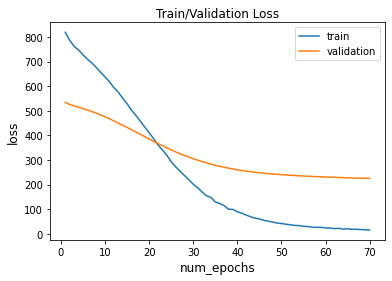

In [49]:
plt.title("Train/Validation Loss")
plt.plot(list(np.arange(70) + 1) , train_loss, label='train')
plt.plot(list(np.arange(70) + 1), valid_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best') 
plt.show()

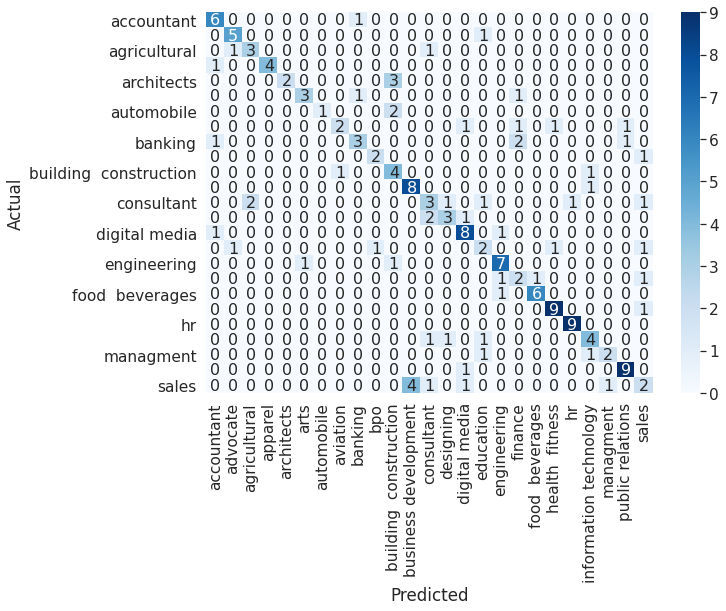

In [55]:
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

Source: [Using Deep Learning for End to End Multiclass Text Classification
Article by Rahul Agarwal | April 02, 2020](https://lionbridge.ai/articles/using-deep-learning-for-end-to-end-multiclass-text-classification/)

[Kaggle Notebook by Rahul Agarwal](https://www.kaggle.com/mlwhiz/multiclass-text-classification-pytorch?scriptVersionId=30273958)

Deep Learning Model: [Convolutional Neural Networks for Sentence Classification by Yoon Kim.](https://www.aclweb.org/anthology/D14-1181/)


Modified as per requirement